# 📊 Scoring Model Project

Скоринговая модель на основе логистической регрессии и WOE-трансформации.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from statsmodels.api import Logit, add_constant
from patsy import dmatrices

import warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv("tr_for_students.419333.csv")
val = pd.read_csv("tr_for_students.419332.csv") 

In [3]:
# Определим целевую переменную и типы признаков
target = 'def'
categorical_features = ['purpose', 'addr_state', 'sub_grade', 'home_ownership']
numerical_features = ['installment', 'dti', 'funded_amnt', 'annual_inc', 'emp_length',
                      'term', 'inq_last_6mths', 'mths_since_recent_inq', 'delinq_2yrs',
                      'chargeoff_within_12_mths', 'num_accts_ever_120_pd',
                      'num_tl_90g_dpd_24m', 'acc_open_past_24mths',
                      'avg_cur_bal', 'tot_hi_cred_lim', 'delinq_amnt']


Размерность датасета: (61169, 23)
Количество дубликатов: 0

Описательная статистика:

        installment           dti   funded_amnt    annual_inc    emp_length  \
count  61169.000000  61169.000000  61169.000000  6.116900e+04  58495.000000   
mean     432.671268     16.782808  14159.664618  7.271755e+04      6.025284   
std      243.699189      7.531950   8181.125909  4.954698e+04      3.597447   
min        4.930000      0.000000   1000.000000  6.695000e+03      0.000000   
25%      257.540000     11.180000   8000.000000  4.500000e+04      3.000000   
50%      382.490000     16.500000  12000.000000  6.250000e+04      6.000000   
75%      565.310000     22.200000  20000.000000  8.800000e+04     10.000000   
max     1408.130000     34.990000  35000.000000  3.900000e+06     10.000000   

               term  inq_last_6mths  mths_since_recent_inq   delinq_2yrs  \
count  61169.000000    61169.000000           47640.000000  61169.000000   
mean      42.276120        0.831254               

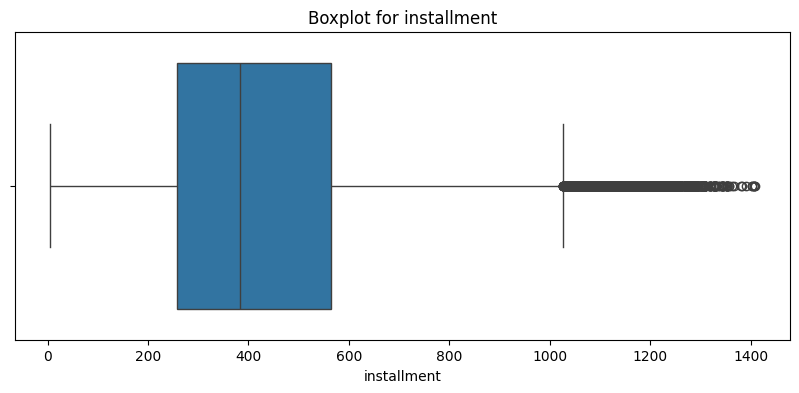

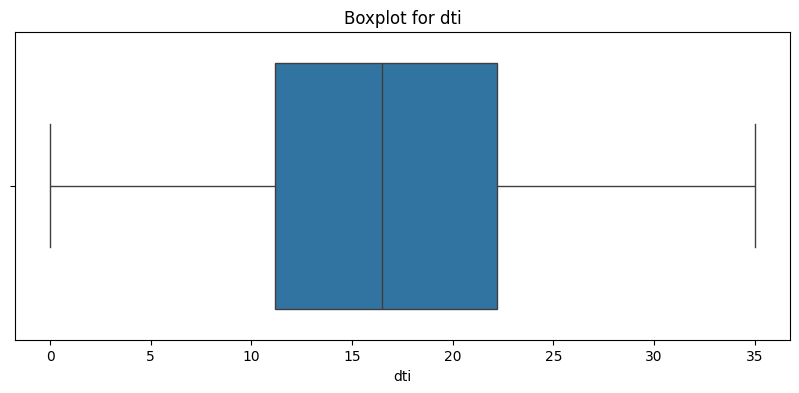

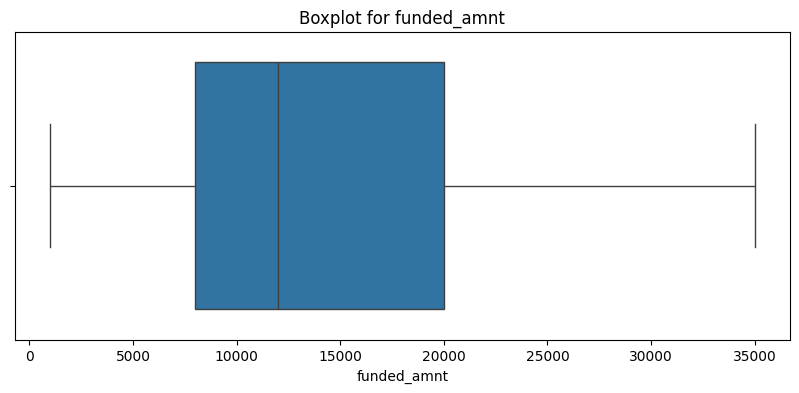

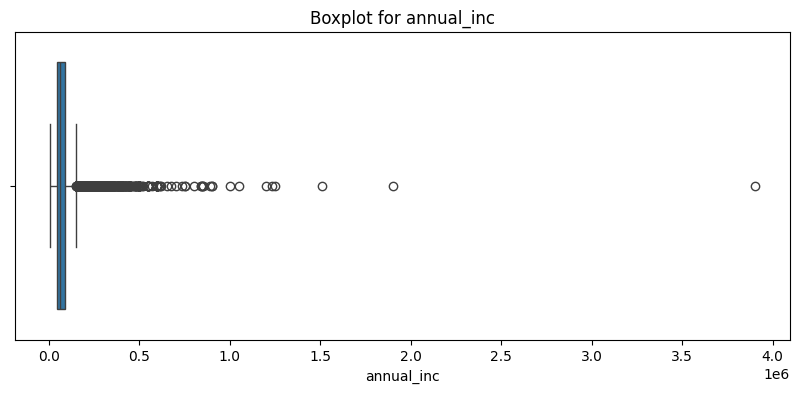

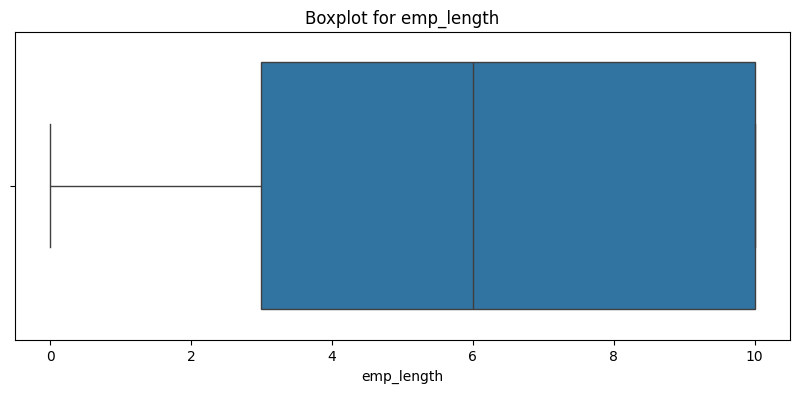

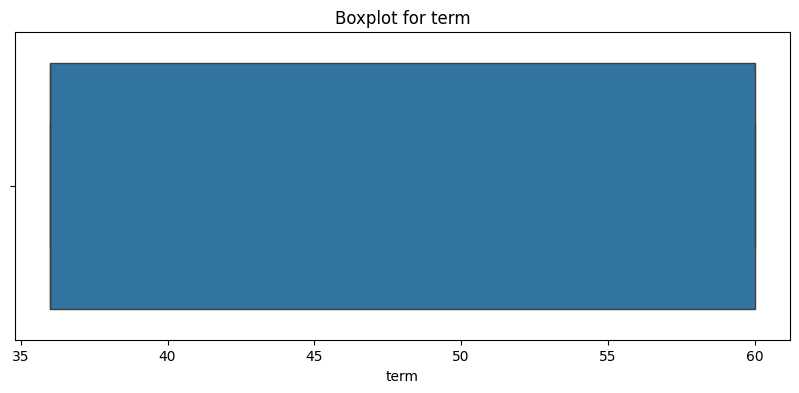

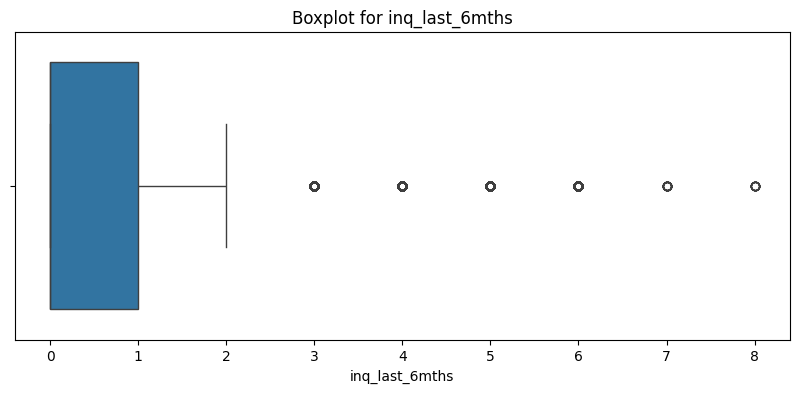

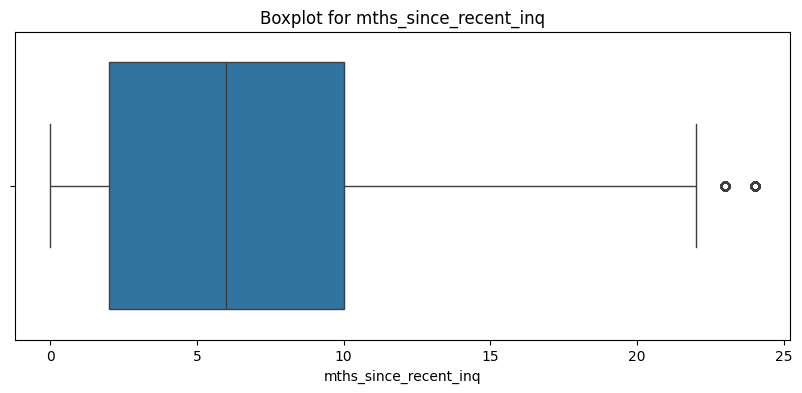

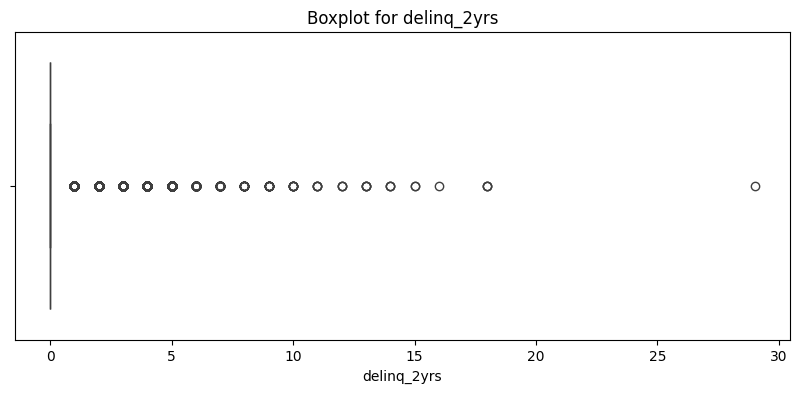

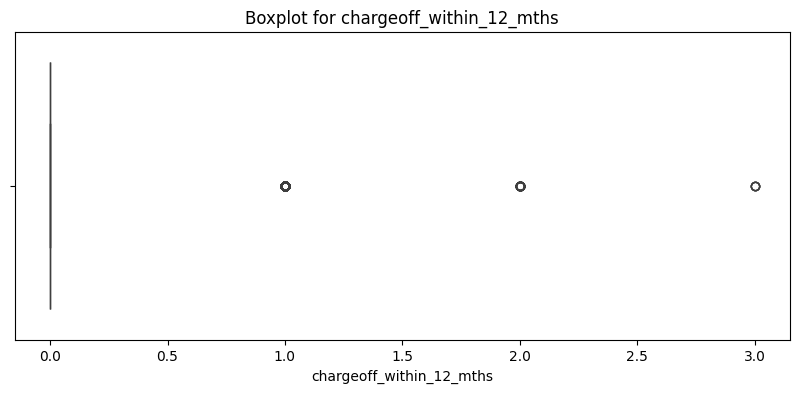

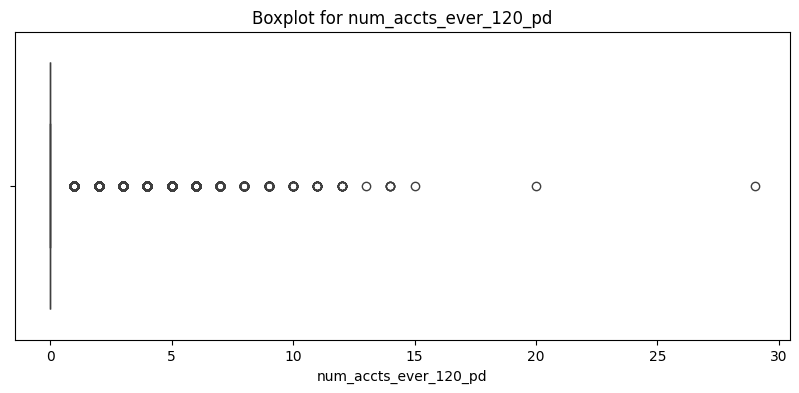

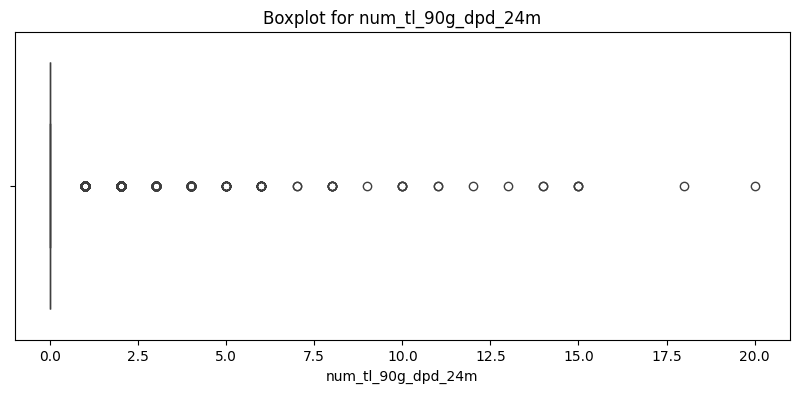

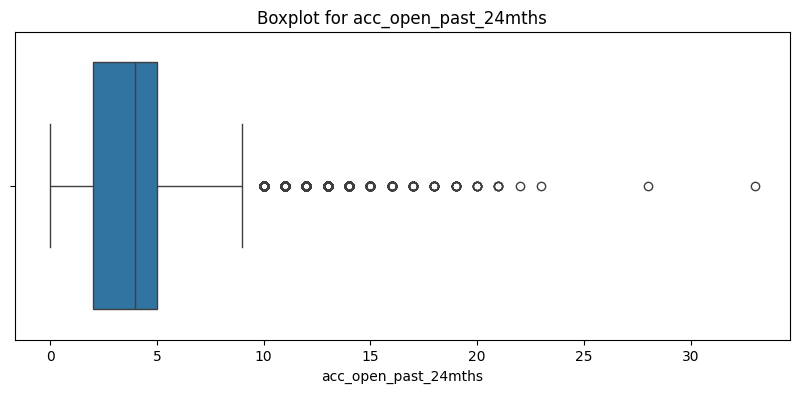

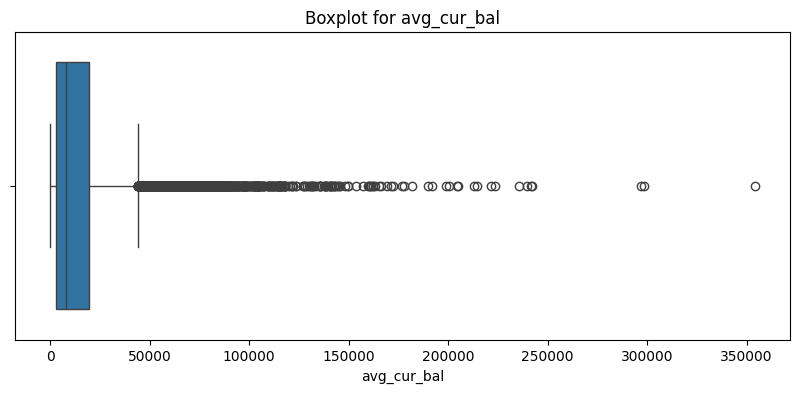

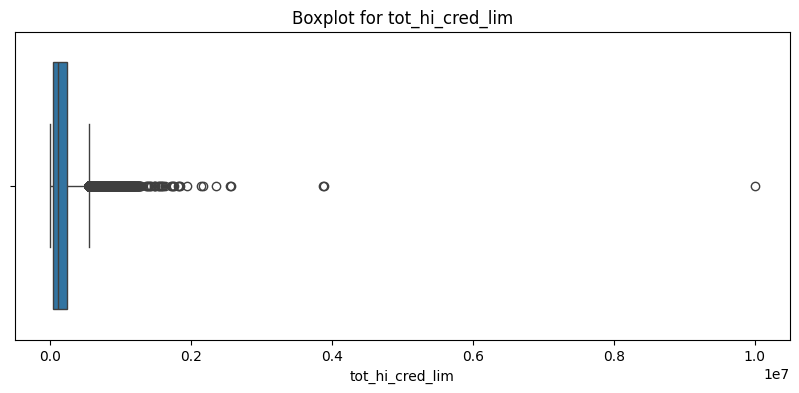

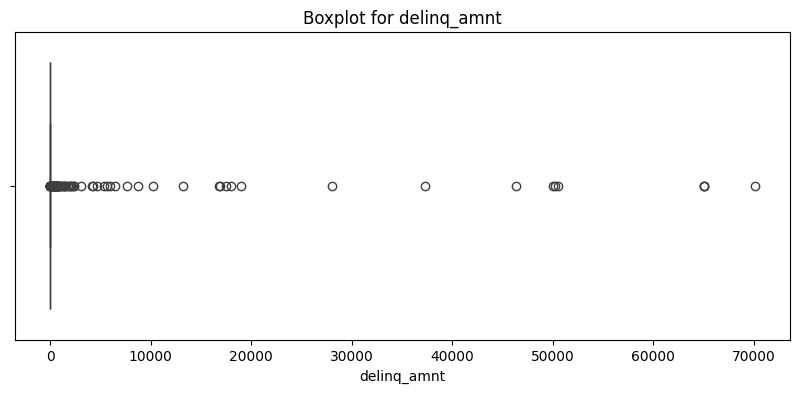


Типы данных:

issue_d                      object
purpose                      object
addr_state                   object
sub_grade                    object
home_ownership               object
emp_title                    object
installment                 float64
dti                         float64
funded_amnt                   int64
annual_inc                  float64
emp_length                  float64
term                          int64
inq_last_6mths                int64
mths_since_recent_inq       float64
delinq_2yrs                   int64
chargeoff_within_12_mths      int64
num_accts_ever_120_pd       float64
num_tl_90g_dpd_24m          float64
acc_open_past_24mths        float64
avg_cur_bal                 float64
tot_hi_cred_lim             float64
delinq_amnt                   int64
def                           int64
dtype: object

Уникальные значения для purpose: ['debt_consolidation' 'credit_card' 'home_improvement' 'car'
 'small_business' 'wedding' 'other' 'moving' 'ma

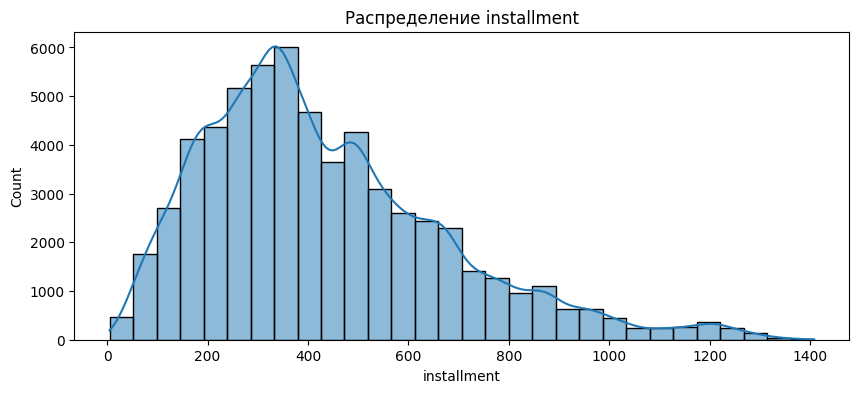

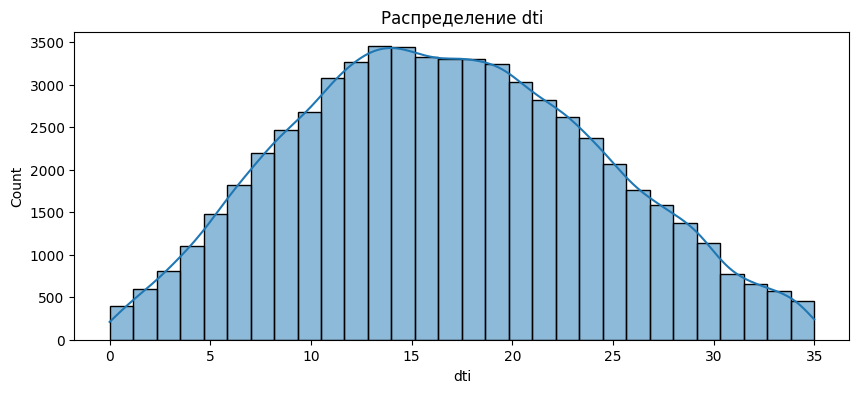

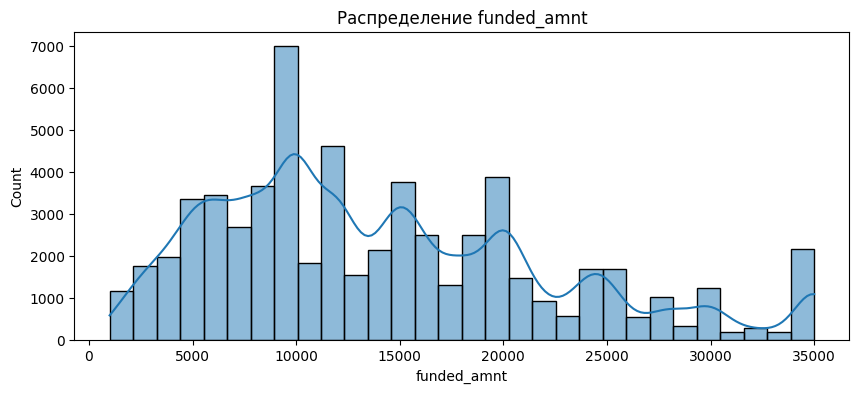

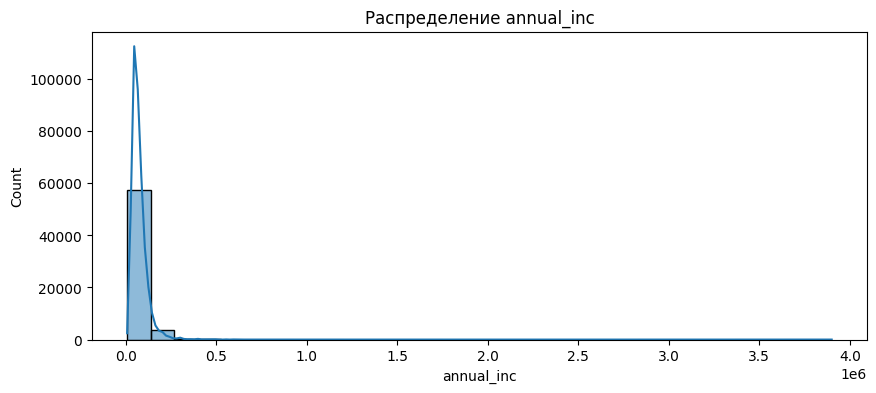

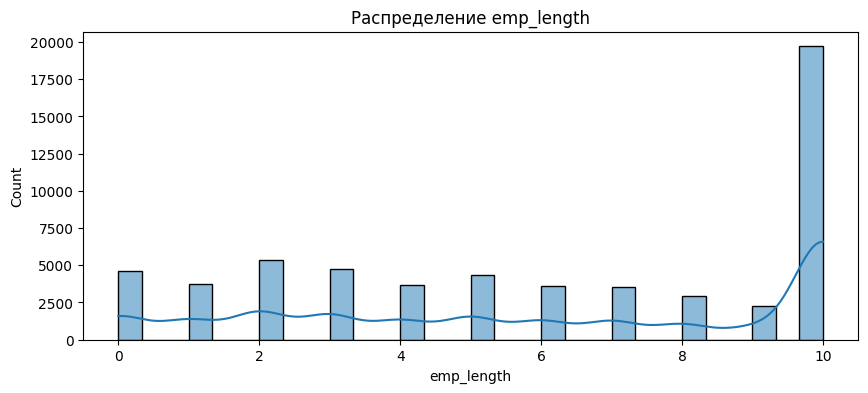

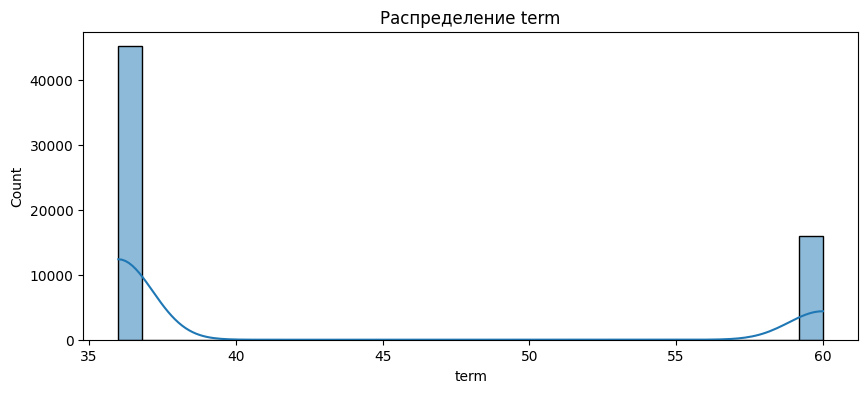

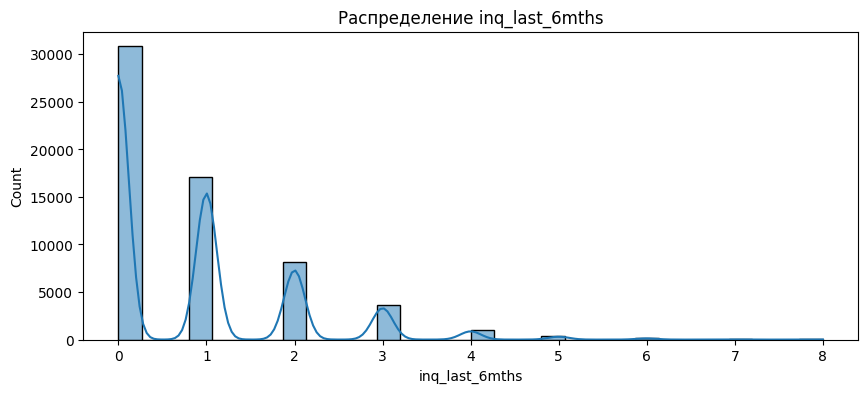

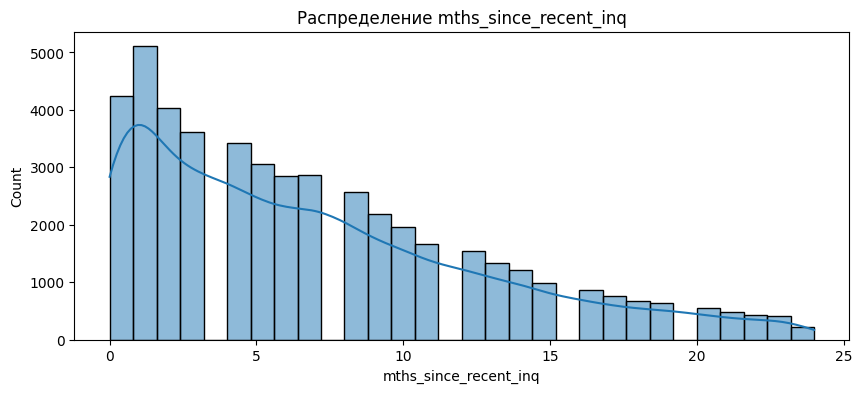

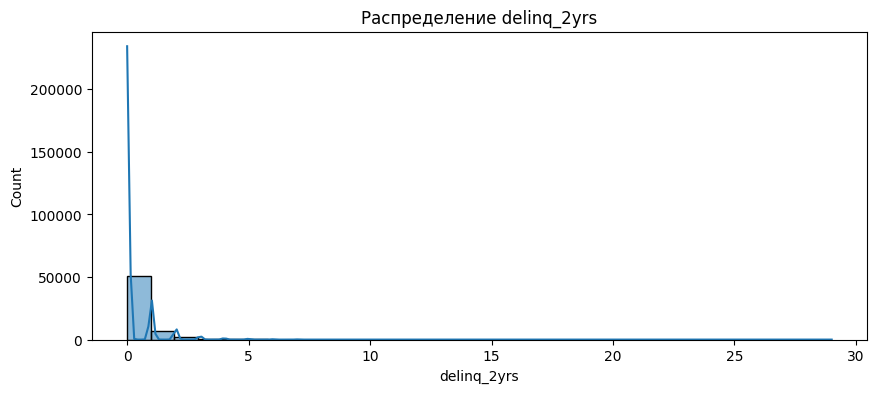

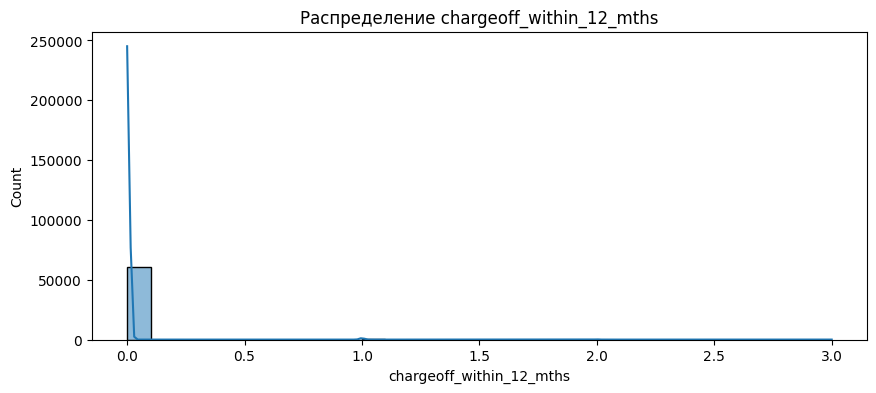

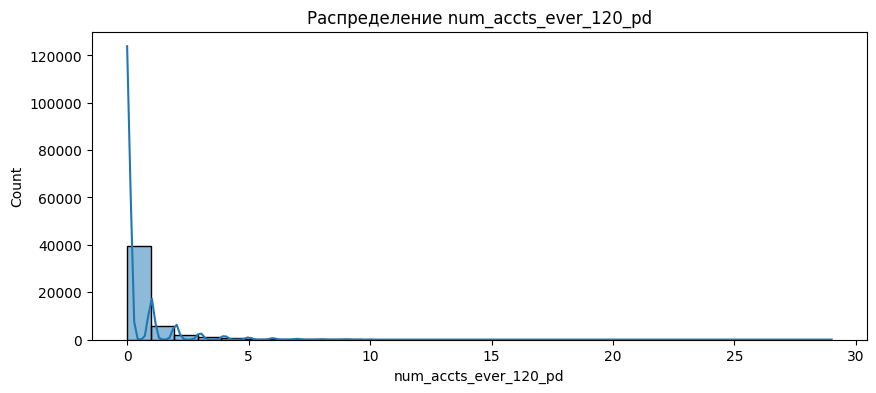

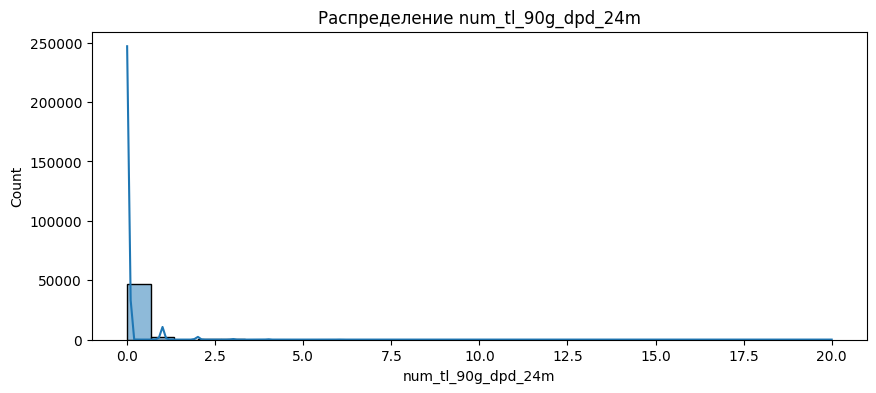

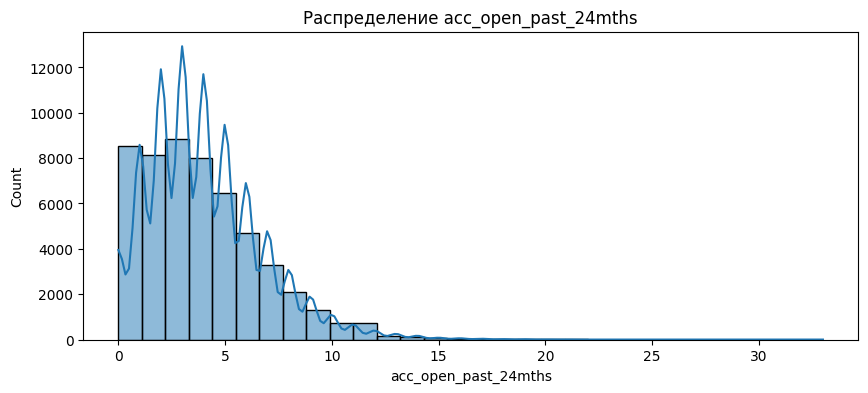

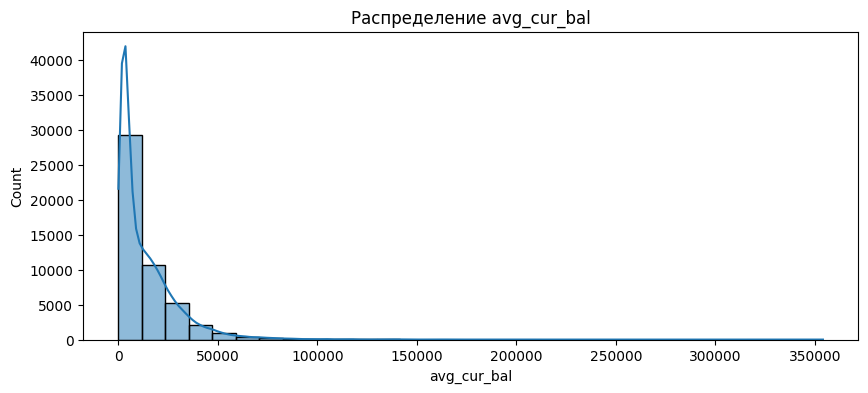

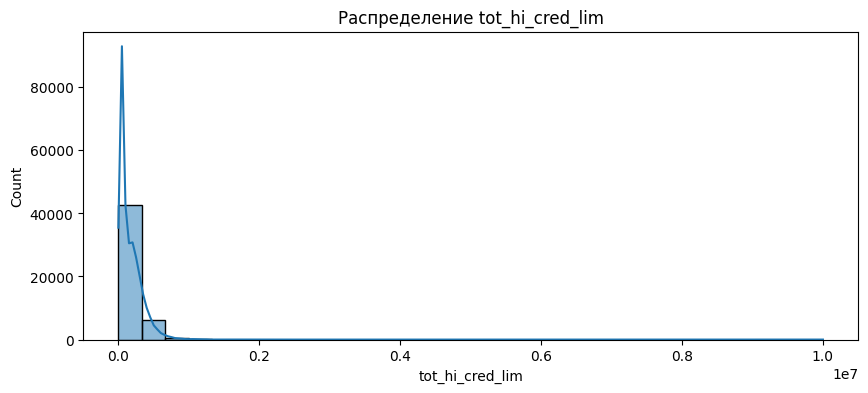

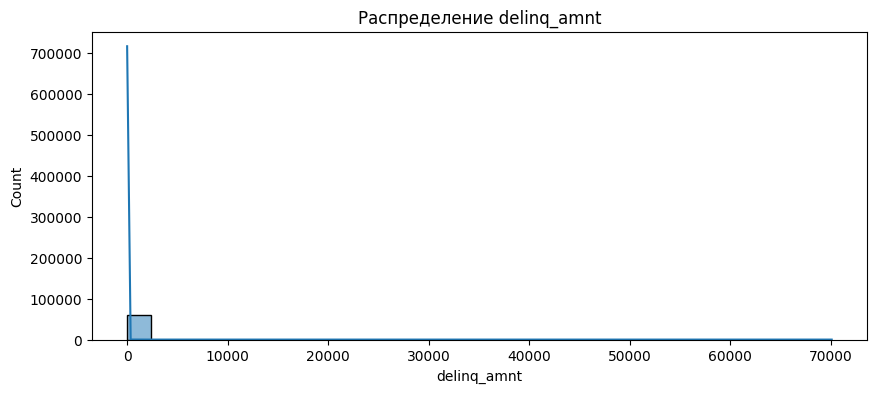

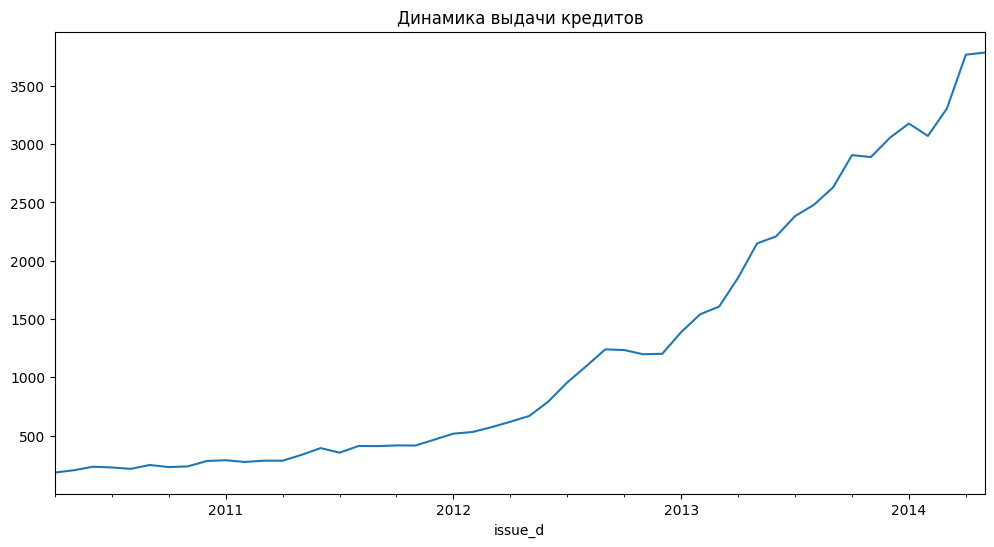

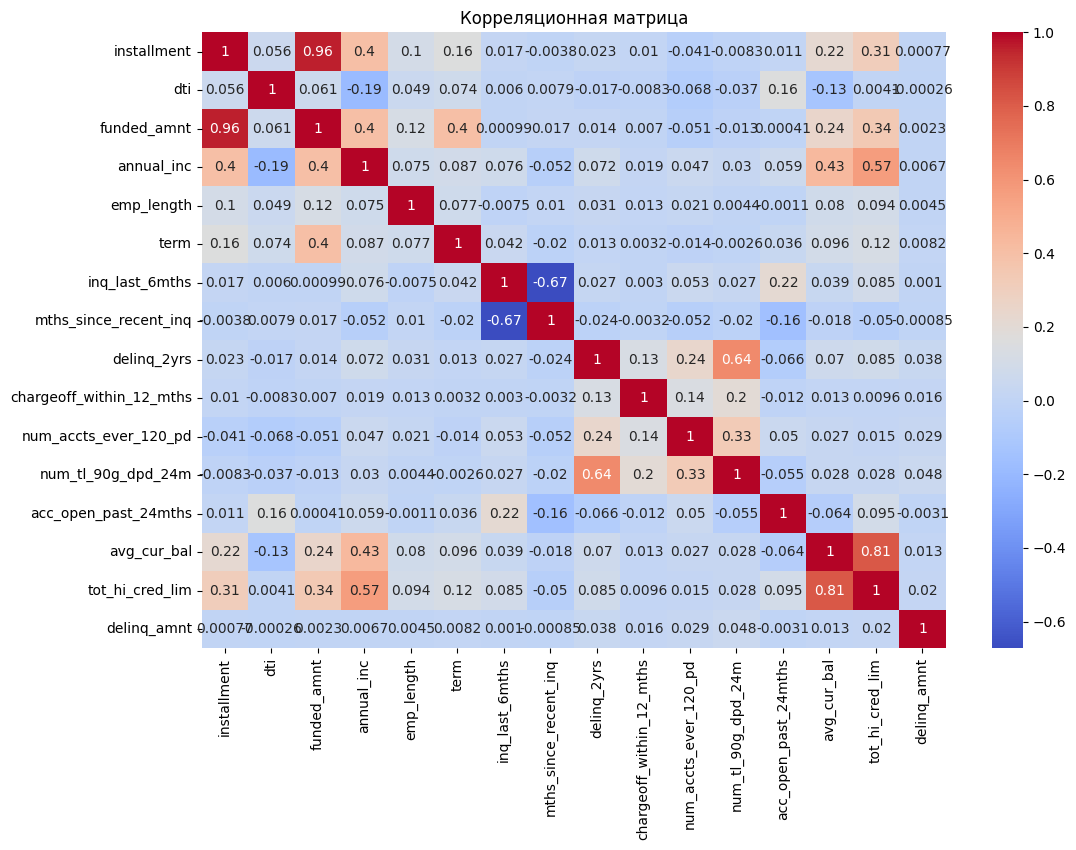

In [4]:
# Чек-лист для первичного анализа данных
# 1. Проверить размерность (shape) датасета
print(f"Размерность датасета: {train.shape}")

# 2. Проверка на наличие дубликатов
duplicates = train.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")

# 3. Построить Descriptive statistics (описательная статистика)
print("\nОписательная статистика:\n")
print(train.describe())

# 4. Проверка доли пропущенных значений
missing_values = train.isnull().mean() * 100
print("\nДоля пропущенных значений (в %):\n")
print(missing_values[missing_values > 0])

# 5. Проверка на наличие выбросов (outliers)
for col in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=train[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# 6. Проверить тип данных
print("\nТипы данных:\n")
print(train.dtypes)

# 7. Посмотреть уникальные значения факторов / целевой переменной
for col in categorical_features + [target]:
    print(f"\nУникальные значения для {col}: {train[col].unique()}")

# 8. Построить распределение значений факторов
for col in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f"Распределение {col}")
    plt.show()

# 9. Посмотреть на динамику переменных (если есть временная составляющая)
if 'issue_d' in train.columns:
    train['issue_d'] = pd.to_datetime(train['issue_d'])
    time_series = train.groupby(train['issue_d'].dt.to_period('M')).size()
    time_series.plot(figsize=(12, 6), title="Динамика выдачи кредитов")
    plt.show()

# 10. Убрать лишние столбцы
columns_to_drop = ['emp_title']  # Пример: удаляем столбец, который не нужен
train = train.drop(columns=columns_to_drop, errors='ignore')

# 11. Построить корреляционную матрицу
correlation_matrix = train[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()


In [5]:
# Самописная функция WOE и IV
def woe_iv(df, feature, target, bins=10, is_cat=False):
    tmp = df[[feature, target]].copy()
    if not is_cat:
        tmp[feature] = pd.qcut(tmp[feature], q=bins, duplicates='drop')
    grouped = tmp.groupby(feature)

    result = pd.DataFrame()
    result['n_total'] = grouped[target].count()
    result['n_event'] = grouped[target].sum()
    result['n_non_event'] = result['n_total'] - result['n_event']

    result['dist_event'] = result['n_event'] / result['n_event'].sum()
    result['dist_non_event'] = result['n_non_event'] / result['n_non_event'].sum()

    result['woe'] = np.log((result['dist_non_event'] + 1e-6) / (result['dist_event'] + 1e-6))
    result['iv'] = (result['dist_non_event'] - result['dist_event']) * result['woe']
    
    iv = result['iv'].sum()
    result = result.reset_index()
    
    return result, iv


In [6]:
# Словарь для хранения WOE-результатов и IV
woe_dict = {}
iv_summary = {}

# Числовые фичи
for col in numerical_features:
    try:
        woe_table, iv = woe_iv(train, col, target, bins=5, is_cat=False)
        woe_dict[col] = woe_table
        iv_summary[col] = iv
    except Exception as e:
        print(f"Ошибка в {col}: {e}")

# Категориальные фичи
for col in categorical_features:
    try:
        woe_table, iv = woe_iv(train, col, target, is_cat=True)
        woe_dict[col] = woe_table
        iv_summary[col] = iv
    except Exception as e:
        print(f"Ошибка в {col}: {e}")

# Топ переменные по IV
sorted(iv_summary.items(), key=lambda x: x[1], reverse=True)


[('sub_grade', np.float64(0.37221638062861373)),
 ('acc_open_past_24mths', np.float64(0.04445138152234032)),
 ('dti', np.float64(0.03998293537487618)),
 ('annual_inc', np.float64(0.034192444724611186)),
 ('avg_cur_bal', np.float64(0.03225180058935972)),
 ('purpose', np.float64(0.02975566774710944)),
 ('tot_hi_cred_lim', np.float64(0.026339036167114187)),
 ('funded_amnt', np.float64(0.02191795424882922)),
 ('mths_since_recent_inq', np.float64(0.0214468581571681)),
 ('inq_last_6mths', np.float64(0.018760838884453006)),
 ('addr_state', np.float64(0.01824937822012756)),
 ('home_ownership', np.float64(0.013706016364468037)),
 ('installment', np.float64(0.012235287872882954)),
 ('emp_length', np.float64(2.795349978291153e-05)),
 ('term', np.float64(0.0)),
 ('delinq_2yrs', np.float64(0.0)),
 ('chargeoff_within_12_mths', np.float64(0.0)),
 ('num_accts_ever_120_pd', np.float64(0.0)),
 ('num_tl_90g_dpd_24m', np.float64(0.0)),
 ('delinq_amnt', np.float64(0.0))]

In [7]:
# Отбор фичей на основе IV
iv_threshold = 0.02  # Устанавливаем порог IV для отбора значимых фичей
selected_features = [feature for feature, iv in iv_summary.items() if iv >= iv_threshold]

print(f"Выбрано {len(selected_features)} фичей из {len(iv_summary)} на основе порога IV >= {iv_threshold}")

# Обновляем списки фичей для дальнейшего анализа
numerical_features = [feature for feature in numerical_features if feature in selected_features]
categorical_features = [feature for feature in categorical_features if feature in selected_features]


Выбрано 9 фичей из 20 на основе порога IV >= 0.02


In [9]:
# Сортируем фичи по IV в порядке убывания
sorted_features = sorted(iv_summary.items(), key=lambda x: x[1], reverse=True)
sorted_features = [feature for feature, iv in sorted_features]

# Применяем WOE-трансформацию к обучающему датасету
def apply_woe(df, woe_dict):
	df_woe = df.copy()
	for feature, woe_table in woe_dict.items():
		if feature in df.columns:
			woe_map = dict(zip(woe_table[feature], woe_table['woe']))
			df_woe[feature] = df[feature].map(woe_map)
	return df_woe

train_woe = apply_woe(train, woe_dict)

# Применяем WOE-трансформацию только к отсортированным фичам
train_woe_sorted = train_woe[sorted_features + [target]]
train_woe_sorted.head()


,sub_grade,acc_open_past_24mths,dti,annual_inc,avg_cur_bal,purpose,tot_hi_cred_lim,funded_amnt,mths_since_recent_inq,inq_last_6mths,...,home_ownership,installment,emp_length,term,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,delinq_amnt,def
0,-0.168082,NaN,-0.001492,-0.222925,NaN,-0.068905,NaN,0.181276,NaN,-0.320895,...,-0.126469,0.174365,-0.002704,0.0,0.0,0.0,NaN,NaN,0.0,0
1,0.249935,-0.022571,-0.001492,0.130388,0.371464,-0.068905,-0.056677,-0.091819,-0.054168,0.073880,...,0.112328,-0.063563,0.006741,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.284274,-0.152362,0.135730,0.130388,-0.114917,-0.068905,-0.109120,-0.229507,0.177159,0.073880,...,-0.126469,-0.063563,-0.005226,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.075669,0.110113,-0.001492,-0.123913,-0.147124,-0.068905,-0.172462,0.103151,0.052689,0.073880,...,0.112328,-0.060748,0.006741,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.394774,-0.152362,-0.123544,-0.023624,-0.114917,0.205865,-0.109120,0.049272,0.052689,-0.320895,...,0.112328,-0.123773,-0.002704,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
# Обучим логистическую регрессию
# Разделим данные на признаки и целевую переменную
X_train = train_woe_sorted[selected_features]
y_train = train_woe_sorted[target]

# Обработка пропущенных значений (импутация средним значением)
X_train = X_train.fillna(X_train.mean())

# Инициализируем модель логистической регрессии
model = LogisticRegression(max_iter=1000)

# Обучим модель
model.fit(X_train, y_train)

# Предсказания на обучающей выборке
y_pred_train = model.predict_proba(X_train)[:, 1]

# Рассчитаем Gini на обучающей выборке
gini_train = 2 * roc_auc_score(y_train, y_pred_train) - 1
print(f"Gini (train): {gini_train}")


Gini (train): 0.37040962739767047


In [13]:
# Преобразуем валидационный датасет
val_woe = apply_woe(val, woe_dict)
val_woe[target] = val[target]
val_woe = val_woe.dropna()

# Предсказания и Gini
X_val = val_woe[selected_features]
y_val = val_woe[target]
y_pred_val = model.predict_proba(X_val)[:, 1]
gini_val = 2 * roc_auc_score(y_val, y_pred_val) - 1
gini_val


np.float64(0.20000000000000018)

In [18]:
# Таблица скоркарты
scorecard = []
for feature in woe_dict:
    if feature in train_woe.columns:  # Ensure the feature exists in train_woe
        df = woe_dict[feature].copy()
        df['feature'] = feature
        if feature in selected_features:
            df['coef'] = model.coef_[0][selected_features.index(feature)]
        else:
            print(f"Feature '{feature}' is not in selected_features. Skipping.")
            continue
        df['score_contribution'] = df['woe'] * df['coef']
        scorecard.append(df)
    else:
        print(f"Feature '{feature}' not found in train_woe.columns. Skipping.")

scorecard_df = pd.concat(scorecard, ignore_index=True)

# Dynamically retrieve the feature column name from the WOE table
feature_column_name = scorecard_df['feature'].iloc[0] if 'feature' in scorecard_df.columns else None

if feature_column_name:
    scorecard_df = scorecard_df[['feature', feature_column_name, 'woe', 'coef', 'score_contribution']]
else:
    print("Error: Feature column not found in the scorecard DataFrame.")

scorecard_df.head()


Feature 'installment' is not in selected_features. Skipping.
Feature 'emp_length' is not in selected_features. Skipping.
Feature 'term' is not in selected_features. Skipping.
Feature 'inq_last_6mths' is not in selected_features. Skipping.
Feature 'delinq_2yrs' is not in selected_features. Skipping.
Feature 'chargeoff_within_12_mths' is not in selected_features. Skipping.
Feature 'num_accts_ever_120_pd' is not in selected_features. Skipping.
Feature 'num_tl_90g_dpd_24m' is not in selected_features. Skipping.
Feature 'delinq_amnt' is not in selected_features. Skipping.
Feature 'addr_state' is not in selected_features. Skipping.
Feature 'home_ownership' is not in selected_features. Skipping.


,feature,dti,woe,coef,score_contribution
0,dti,"(-0.001, 9.93]",0.319746,-0.291688,-0.093266
1,dti,"(9.93, 14.38]",0.135730,-0.291688,-0.039591
2,dti,"(14.38, 18.67]",-0.001492,-0.291688,0.000435
3,dti,"(18.67, 23.57]",-0.123544,-0.291688,0.036036
4,dti,"(23.57, 34.99]",-0.262146,-0.291688,0.076465


In [21]:
# VIF и p-value
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_const).fit(disp=0)

# p-values
pvals = logit_model.pvalues

# VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X_train.columns
vif_df["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_df["p-value"] = pvals[1:].values  # без const

vif_df.sort_values("VIF", ascending=False)


,feature,VIF,p-value
6,tot_hi_cred_lim,3.351352,9.971772e-01
5,avg_cur_bal,2.826187,3.112492e-03
2,annual_inc,1.641688,6.328597e-68
1,funded_amnt,1.395215,1.589080e-43
8,sub_grade,1.201659,0.000000e+00
0,dti,1.172699,3.287908e-06
4,acc_open_past_24mths,1.114850,8.057606e-30
3,mths_since_recent_inq,1.059122,1.917750e-03
7,purpose,1.029028,7.548144e-15
